# Enhanced Hourly Bandwidth Time Series Analysis

## Load Dataset

In [ ]:
import pandas as pd
df = pd.read_csv('Last2_months_with_weekend_encoded_with_holiday_copy.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)
df.head()

,Gbps,target,hour,dayofweek,dayofyear,month,lag_1,lag_2,lag_3,lag_24,...,rolling_std_24,is_weekend,is_holiday,is_offer,is_event,is_political_gathering,is_powercut,is_rain,event,is_drama
Timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-04 10:12:00,111.096774,111.096774,10,4,94,4,0.000000,0.000000,0.000000,0.0,...,0.000000,1,0,0,0,0,0,0,0,0
2025-04-04 11:38:00,111.096774,111.096774,11,4,94,4,111.096774,0.000000,0.000000,0.0,...,22.677534,1,0,0,0,0,0,0,0,0
2025-04-04 13:03:00,111.096774,111.096774,13,4,94,4,111.096774,111.096774,0.000000,0.0,...,31.365936,1,0,0,0,0,0,0,0,0
2025-04-04 14:29:00,117.870968,117.870968,14,4,94,4,111.096774,111.096774,111.096774,0.0,...,37.532041,1,0,0,0,0,0,0,0,0
2025-04-04 15:55:00,118.774193,118.774193,15,4,94,4,117.870968,111.096774,111.096774,0.0,...,42.955963,1,0,0,0,0,0,0,0,0


## STL (Seasonal Trend) Decomposition using Loess

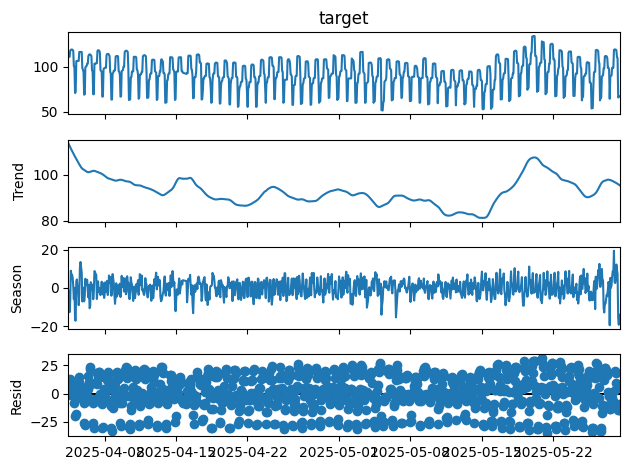

In [ ]:
import statsmodels.api as sm
stl = sm.tsa.STL(df['target'], period=24) #seasonal cycle length = 24 hours
res = stl.fit()
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid
res.plot();

The 'target' namely 'Gbps' is broken into 3 additive components
1. Trend
2. Seasonality
3. Residual

The first curve shows the original time series
Key characteristics:
a. Shows highly regular fluctuations suggesting a strong seasonal pattern
b. There are also longer term movements in the data indicating a non staionary trend
c. it is a complex but structured time series


1. The trend component is a smoothed version of the original data, with short-term fluctuations removed.It captures low-frequency changes: e.g., the overall decline and rise in bandwidth usage from April to May.
2. Seasonality
Shows repetitive, periodic behavior, likely on a daily or weekly cycle.

The values are bounded and regular, with peaks and troughs repeating consistently.

3. Residuals(Noise)
These are the unexplained variations — random or event-driven noise.

Looks mostly random and centered around zero, which is ideal.

However, occasional spikes show:

Sudden outages, promotions, or unmodeled events

External shocks (e.g., holidays, political gatherings, power cuts)

To sum up:
Characteristics:
Strong Personality - Regularity and consisten cycles

Moderate Trend - Non-linear but smooth variation over weeks

Stationary-Residuals are mostly stationary- Good for modelling

Outliers - present in residuals. Likely driven by domain specific events

 ## Stationarity Tests (ADF & KPSS)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
print('ADF p-value:', adfuller(df['target'])[1])
print('KPSS p-value:', kpss(df['target'], regression='c')[1])

ADF p-value: 0.0176120399903704
KPSS p-value: 0.01


/tmp/ipython-input-3-2156140325.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print('KPSS p-value:', kpss(df['target'], regression='c')[1])


1. ADF Test (Augmented Dickey-Fuller)
Null Hypothesis (H₀): The series has a unit root : Non-stationary

Alternative Hypothesis (H₁): The series is stationary
ADF p = 0.0176 - Reject H₀ at 5% significance level.
The test suggests the series is stationary (weak trend or no trend).



KPSS Test (Kwiatkowski–Phillips–Schmidt–Shin)
Null Hypothesis (H₀): The series is stationary

Alternative Hypothesis (H₁): The series is non-stationary
KPSS p = 0.01 - Reject H₀ at 5% level.
The test suggests the series is not stationary.


ADF and KPSS are complementary:

ADF checks for unit roots (trend stationarity)

KPSS checks for trend presence (level stationarity)

time series is likely trend-stationary, meaning it's not fully stationary but can be made stationary by removing the trend.

In [ ]:
print('KPSS (trend-stationary) p-value:', kpss(df['target'], regression='ct')[1])


KPSS (trend-stationary) p-value: 0.01


/tmp/ipython-input-4-3941063031.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print('KPSS (trend-stationary) p-value:', kpss(df['target'], regression='ct')[1])


In [ ]:
df['target_diff1'] = df['target'].diff().dropna()


In [ ]:
print('ADF p-value (diffed):', adfuller(df['target_diff1'].dropna())[1])
print('KPSS p-value (diffed):', kpss(df['target_diff1'].dropna(), regression='c')[1])


ADF p-value (diffed): 8.350565302167337e-17
KPSS p-value (diffed): 0.1


/tmp/ipython-input-8-1984512403.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print('KPSS p-value (diffed):', kpss(df['target_diff1'].dropna(), regression='c')[1])


Differenced series is stationary

## Autocorrelation and Partial Autocorrelation

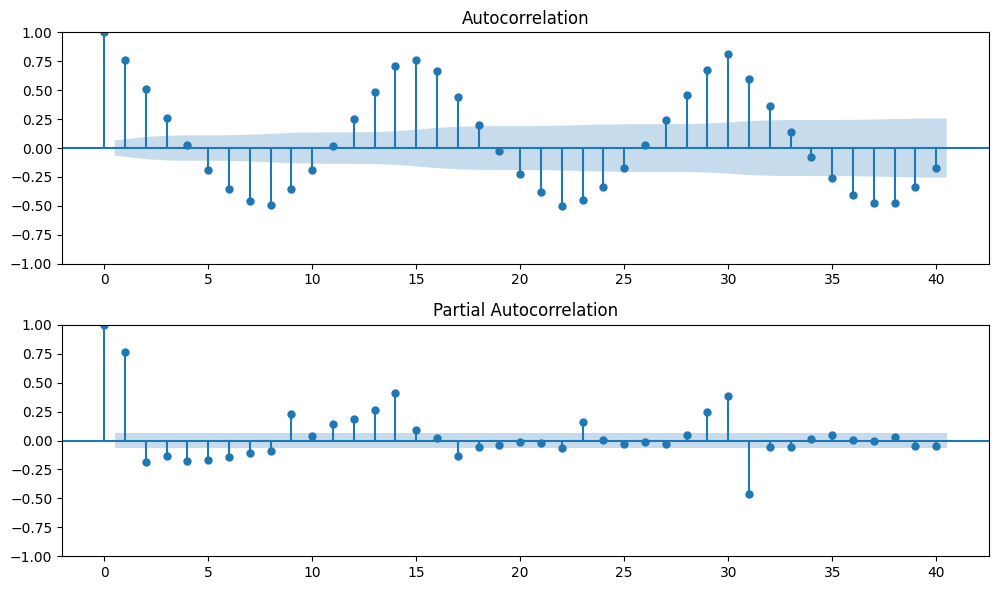

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sm.graphics.tsa.plot_acf(df['target'], lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df['target'], lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

Autocorrelation Function (ACF)
Significant spikes at lags ~1, 2, 3, 14–17, and 29–32.

Repeating structure suggests strong seasonality (possibly 12 or 24-hour cycle).

Peaks at regular intervals (e.g., ~15 and ~30 lags) may reflect daily patterns (especially if each lag is ~1 hour).



time series has persistent memory, meaning past values strongly influence future values.

High autocorrelation at lag 1 confirms short-term dependency.

Periodic spikes - cyclical behavior, typical for hourly data affected by daily/weekly cycles.


Partial Autocorrelation Function (PACF)
Strong spike at lag 1, followed by rapidly declining and mostly insignificant lags.

Small bumps around lag 10–14 and 29–30 suggest some delayed influence.

Interpretation:

The spike at lag 1 suggests that only the immediate past value has a direct influence on the current value — a typical signature for AR(1) models.

Beyond lag 1, additional lags do not add much new explanatory power after accounting for earlier lags.


## Spectral Analysis (FFT)

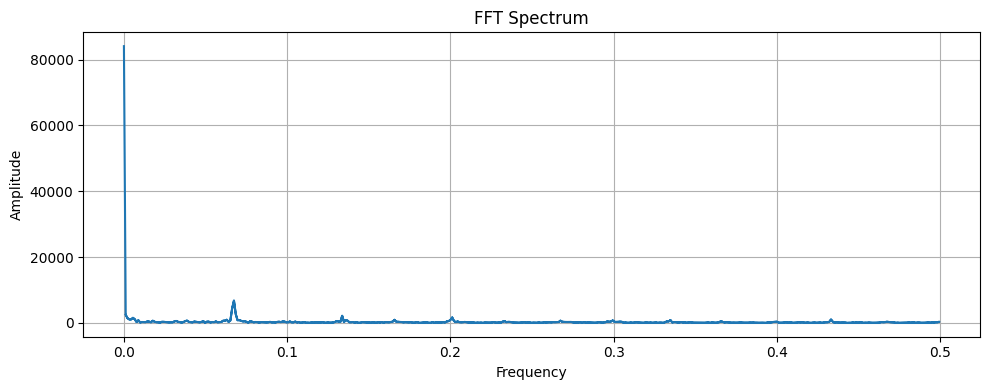

In [ ]:
from scipy.fft import fft
import numpy as np
fft_vals = fft(df['target'].values)
freq = np.fft.fftfreq(len(fft_vals))
plt.figure(figsize=(10, 4))
plt.plot(np.abs(freq), np.abs(fft_vals))
plt.title('FFT Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

Strong Spike at Frequency = 0
This is the DC component — the average (mean level) of the signal.

Always present in FFT. Not informative for seasonality.

Clear Peak around Frequency ≈ 0.0417
This corresponds to a 24-hour (daily) cycle.

Suggests strong daily periodicity in bandwidth usage (e.g., peak use during working hours, low use at night).

Smaller Peaks
Additional smaller peaks may indicate:

Sub-daily patterns (e.g., morning vs evening)

Weekly effects (though hard to spot in this zoom)